In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns


In [2]:
url = 'https://docs.google.com/spreadsheets/d/1aCENVOk-wroyW4-YS4OgtTTqr3rA-T9CZOjCQgALgSE/export?format=xlsx'
xls = pd.ExcelFile(url)


# ---------- get main data -------------
exclude = {"_Competition Factors", "_JPAR Ratings", "_Latest JPAR Ratings", "_Histograms", "_UTILITY FUNCTIONS"}
sheets_to_read = [s for s in xls.sheet_names if s not in exclude]

dfs = {
    name: xls.parse(name, dtype={'Time': str})
    for name in sheets_to_read
}

for name, df in dfs.items():
    fullname = df['Event'].iloc[0]
    df['Full_Event'] = fullname
    
for name, df in dfs.items():
    df['Event'] = name

combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df = combined_df.drop(columns=['Unnamed: 11', 'Unnamed: 12'], errors='ignore')

def time_to_seconds(time_str):
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except Exception:
        return np.nan


combined_df['time_in_seconds'] = combined_df['Time'].apply(time_to_seconds)

def clean_remaining(val):
    if pd.isna(val):
        return 0
    if isinstance(val, str) and re.fullmatch(r"\d{1,2}:\d{2}:\d{2}", val):
        return 0
    return val

combined_df["Remaining"] = combined_df["Remaining"].apply(clean_remaining)

combined_df['time_penalty'] = (((500 - combined_df['Remaining']) / combined_df['time_in_seconds'])**(-1)) * combined_df['Remaining']
combined_df['corrected_time'] = combined_df['time_penalty'] + combined_df['time_in_seconds']

## DATA CLEANING
combined_df['Name'] = combined_df['Name'].str.strip()
combined_df['Pieces'] = pd.to_numeric(combined_df['Pieces'],errors='coerce')

# ---------- get _JPAR Rating Data and merge with main data -------------


sheets_to_read = ['_JPAR Ratings']

dfs = {
    name: xls.parse(name)
    for name in sheets_to_read
}

df = pd.concat(dfs.values(), ignore_index=True)
df = df.rename(columns={"Event Name": "Full_Event","Player Name":"Name"})

merged_df = combined_df.merge(df, on =['Full_Event','Name'],how='left')

merged_df.to_pickle('./data/250221_scrape_with_JPAR_Rating.pkl')

In [33]:
!open .

In [36]:
merged_df.columns

Index(['Rank', 'Name', 'Time', 'Remaining', 'PPM', 'Relative Rank', 'Date',
       'Pieces', 'Event', 'Players', 'Spread Diff', 'Full_Event',
       'time_in_seconds', 'time_penalty', 'corrected_time', 'Event Date',
       'JPAR In', 'JPAR Out', 'Competition Count', 'Current Event Tier',
       'All-Time Average Tier', '12-Month Average Tier',
       'Weighted JPAR Contribution', 'Ave Weighted JPAR Contribution',
       'Player Rank', 'Avg JPAR In (Event)', '12-Month Avg JPAR In',
       'Completion Time', '12-Month Avg Completion Time'],
      dtype='object')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns


data = pd.read_pickle('./data/250519_scape_with_event_names.pkl')



In [54]:

def compute_speed_puzzle_rankings(combined_df, min_puzzles=9, min_event_attempts=1, weighted=True):
    # Copy DataFrame for processing
    df = pd.DataFrame.copy(combined_df)

    # Filter puzzles from the past year
    start_time = pd.Timestamp.today() - pd.DateOffset(years=1)
    df = df[df['Date'] >= start_time]

    # Filter puzzles with enough solvers
    df = df[df['Event'].map(df['Event'].value_counts()) >= min_event_attempts]

    # Add total puzzles completed by each solver
    df['Total_Puzzles'] = df['Name'].map(df['Name'].value_counts())

    # Puzzle-level stats
    puzzle_stats = df.groupby('Event')['corrected_time'].agg(
        mean='mean',
        std='std',
        count='count',
        median='median',
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
    ).reset_index().rename(columns={
        'mean': 'puzzle_mean',
        'median': 'puzzle_median',
        'std': 'puzzle_std',
        'count': 'puzzle_count',
        'iqr': 'puzzle_iqr'
    })

    # Merge stats into main DataFrame
    df = df.merge(puzzle_stats, on='Event', how='left')

    # Handle edge cases for std and iqr
    df.loc[(df['puzzle_count'] == 1) | (df['puzzle_std'] == 0) | (df['puzzle_std'].isna()), 'puzzle_std'] = 1
    df.loc[(df['puzzle_iqr'] == 0) | (df['puzzle_iqr'].isna()), 'puzzle_iqr'] = 1

    # Compute z-scores (higher is better)
    df['z_score'] = - (df['corrected_time'] - df['puzzle_mean']) / df['puzzle_std']

    # Percentile within each puzzle (lower corrected time = better)
    df['percentile'] = df.groupby('Event')['corrected_time'].rank(pct=True, ascending=True) * 100

    # Basic (unweighted) summaries
    z_summary = df.groupby('Name')['z_score'].mean().rename('Norm_Score').to_frame()
    z_summary['Avg_Percentile'] = df.groupby('Name')['percentile'].mean()

    # Weighted versions, if requested
    if weighted:
        df['weighted_z'] = df['z_score'] * df['puzzle_count']
        df['weighted_percentile'] = df['percentile'] * df['puzzle_count']
        weight_sums = df.groupby('Name')['puzzle_count'].sum()
        weighted_z_score = df.groupby('Name')['weighted_z'].sum() / weight_sums
        weighted_percentile = df.groupby('Name')['weighted_percentile'].sum() / weight_sums

        z_summary['Weighted_Norm_Score'] = weighted_z_score
        z_summary['Weighted_Avg_Percentile'] = weighted_percentile

    # Total puzzles per person
    total_puzzles = df['Name'].value_counts().rename('Total_Puzzles')
    z_summary = z_summary.merge(total_puzzles, left_index=True, right_index=True)

    # Filter by minimum puzzle count
    z_summary = z_summary[z_summary['Total_Puzzles'] >= min_puzzles]

    # Assign ranks
    z_summary = z_summary.sort_values(by='Norm_Score', ascending=False)
    z_summary["Z_Score_Rank"] = range(1, len(z_summary) + 1)
    z_summary['Percentile_Rank'] = z_summary['Avg_Percentile'].rank(method='min')

    if weighted:
        z_summary['Weighted_Z_Score_Rank'] = z_summary['Weighted_Norm_Score'].rank(ascending=False, method='min')
        z_summary['Weighted_Percentile_Rank'] = z_summary['Weighted_Avg_Percentile'].rank(method='min')

    # Merge with Rob's rankings
    rob_ranks = pd.read_csv('./data/Puzzle Competitor Data (Cleaned Up) - _Latest JPAR Ratings.csv')
    rob_ranks = rob_ranks.rename(columns={"Player": "Name"})
    rob_ranks = rob_ranks.sort_values(by='Latest JPAR Out')
    rob_ranks["rob_rank"] = range(1, len(rob_ranks) + 1)

    compare_df = rob_ranks.merge(z_summary, on='Name')
    compare_df["rob_rank"] = range(1, len(compare_df) + 1)

    # Final result table
    if weighted:
        results = compare_df[['Name','Total Events','Total_Puzzles','rob_rank','Z_Score_Rank',
                              'Weighted_Z_Score_Rank','Percentile_Rank','Weighted_Percentile_Rank']]
        results['avg_rank'] = results[['rob_rank','Z_Score_Rank','Weighted_Z_Score_Rank',
                                       'Percentile_Rank','Weighted_Percentile_Rank']].mean(axis=1)
    else:
        results = compare_df[['Name','Total Events','Total_Puzzles','rob_rank','Z_Score_Rank','Percentile_Rank']]
        results['avg_rank'] = results[['rob_rank','Z_Score_Rank','Percentile_Rank']].mean(axis=1)

    results = results.sort_values(by='avg_rank')

    # Convert appropriate columns to integers
    int_columns = results.columns[1:-1]
    results[int_columns] = results[int_columns].astype(int)

    # Display index from 1 to 100
    display_index = pd.Index(np.arange(1, 101))

    # drop events temporarily, need to FIX THIS
    results = results.drop(columns=['Total Events'])

    # Styled DataFrame
    if weighted:
        styled_df = (
            results.head(100)
            .set_index(display_index)
            .style
            .background_gradient(subset=[ 'Total_Puzzles'], cmap='Purples')
            .background_gradient(
                subset=['rob_rank', 'Z_Score_Rank', 'Weighted_Z_Score_Rank',
                        'Percentile_Rank', 'Weighted_Percentile_Rank', 'avg_rank'],
                cmap='RdYlGn'
            )
            .format({'avg_rank': '{:.1f}'})
        )
    else:
        styled_df = (
            results.head(100)
            .set_index(display_index)
            .style
            .background_gradient(subset=['Total_Puzzles'], cmap='Purples')
            .background_gradient(
                subset=['rob_rank', 'Z_Score_Rank', 'Percentile_Rank', 'avg_rank'],
                cmap='RdYlGn'
            )
            .format({'avg_rank': '{:.1f}'})
        )


    return styled_df, results.reset_index(drop=True).head(100)


In [55]:
styled_df, results = compute_speed_puzzle_rankings(data, min_puzzles=10, min_event_attempts=1, weighted=False)

/var/folders/cy/44gytg3d3xdfyq3bqsv7zhm40000gn/T/ipykernel_50883/3827389147.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['avg_rank'] = results[['rob_rank','Z_Score_Rank','Percentile_Rank']].mean(axis=1)


In [59]:
styled_df

,Name,Total_Puzzles,rob_rank,Z_Score_Rank,Percentile_Rank,avg_rank
1,Kristin Thuv,13,2,1,1,1.3
2,Wiktor Kacprzak,23,4,2,4,3.3
3,Katharina Reiner,11,1,8,6,5.0
4,Lauren Kautz,15,5,10,2,5.7
5,Mari Black,38,8,6,3,5.7
6,Kathi Reiner,11,7,3,8,6.0
7,Andrea Peng,36,13,4,5,7.3
8,Conner DeLaat,13,3,12,10,8.3
9,Chiara Dellantonio,25,6,9,11,8.7
10,Hanna Lehikoinen,22,9,7,14,10.0


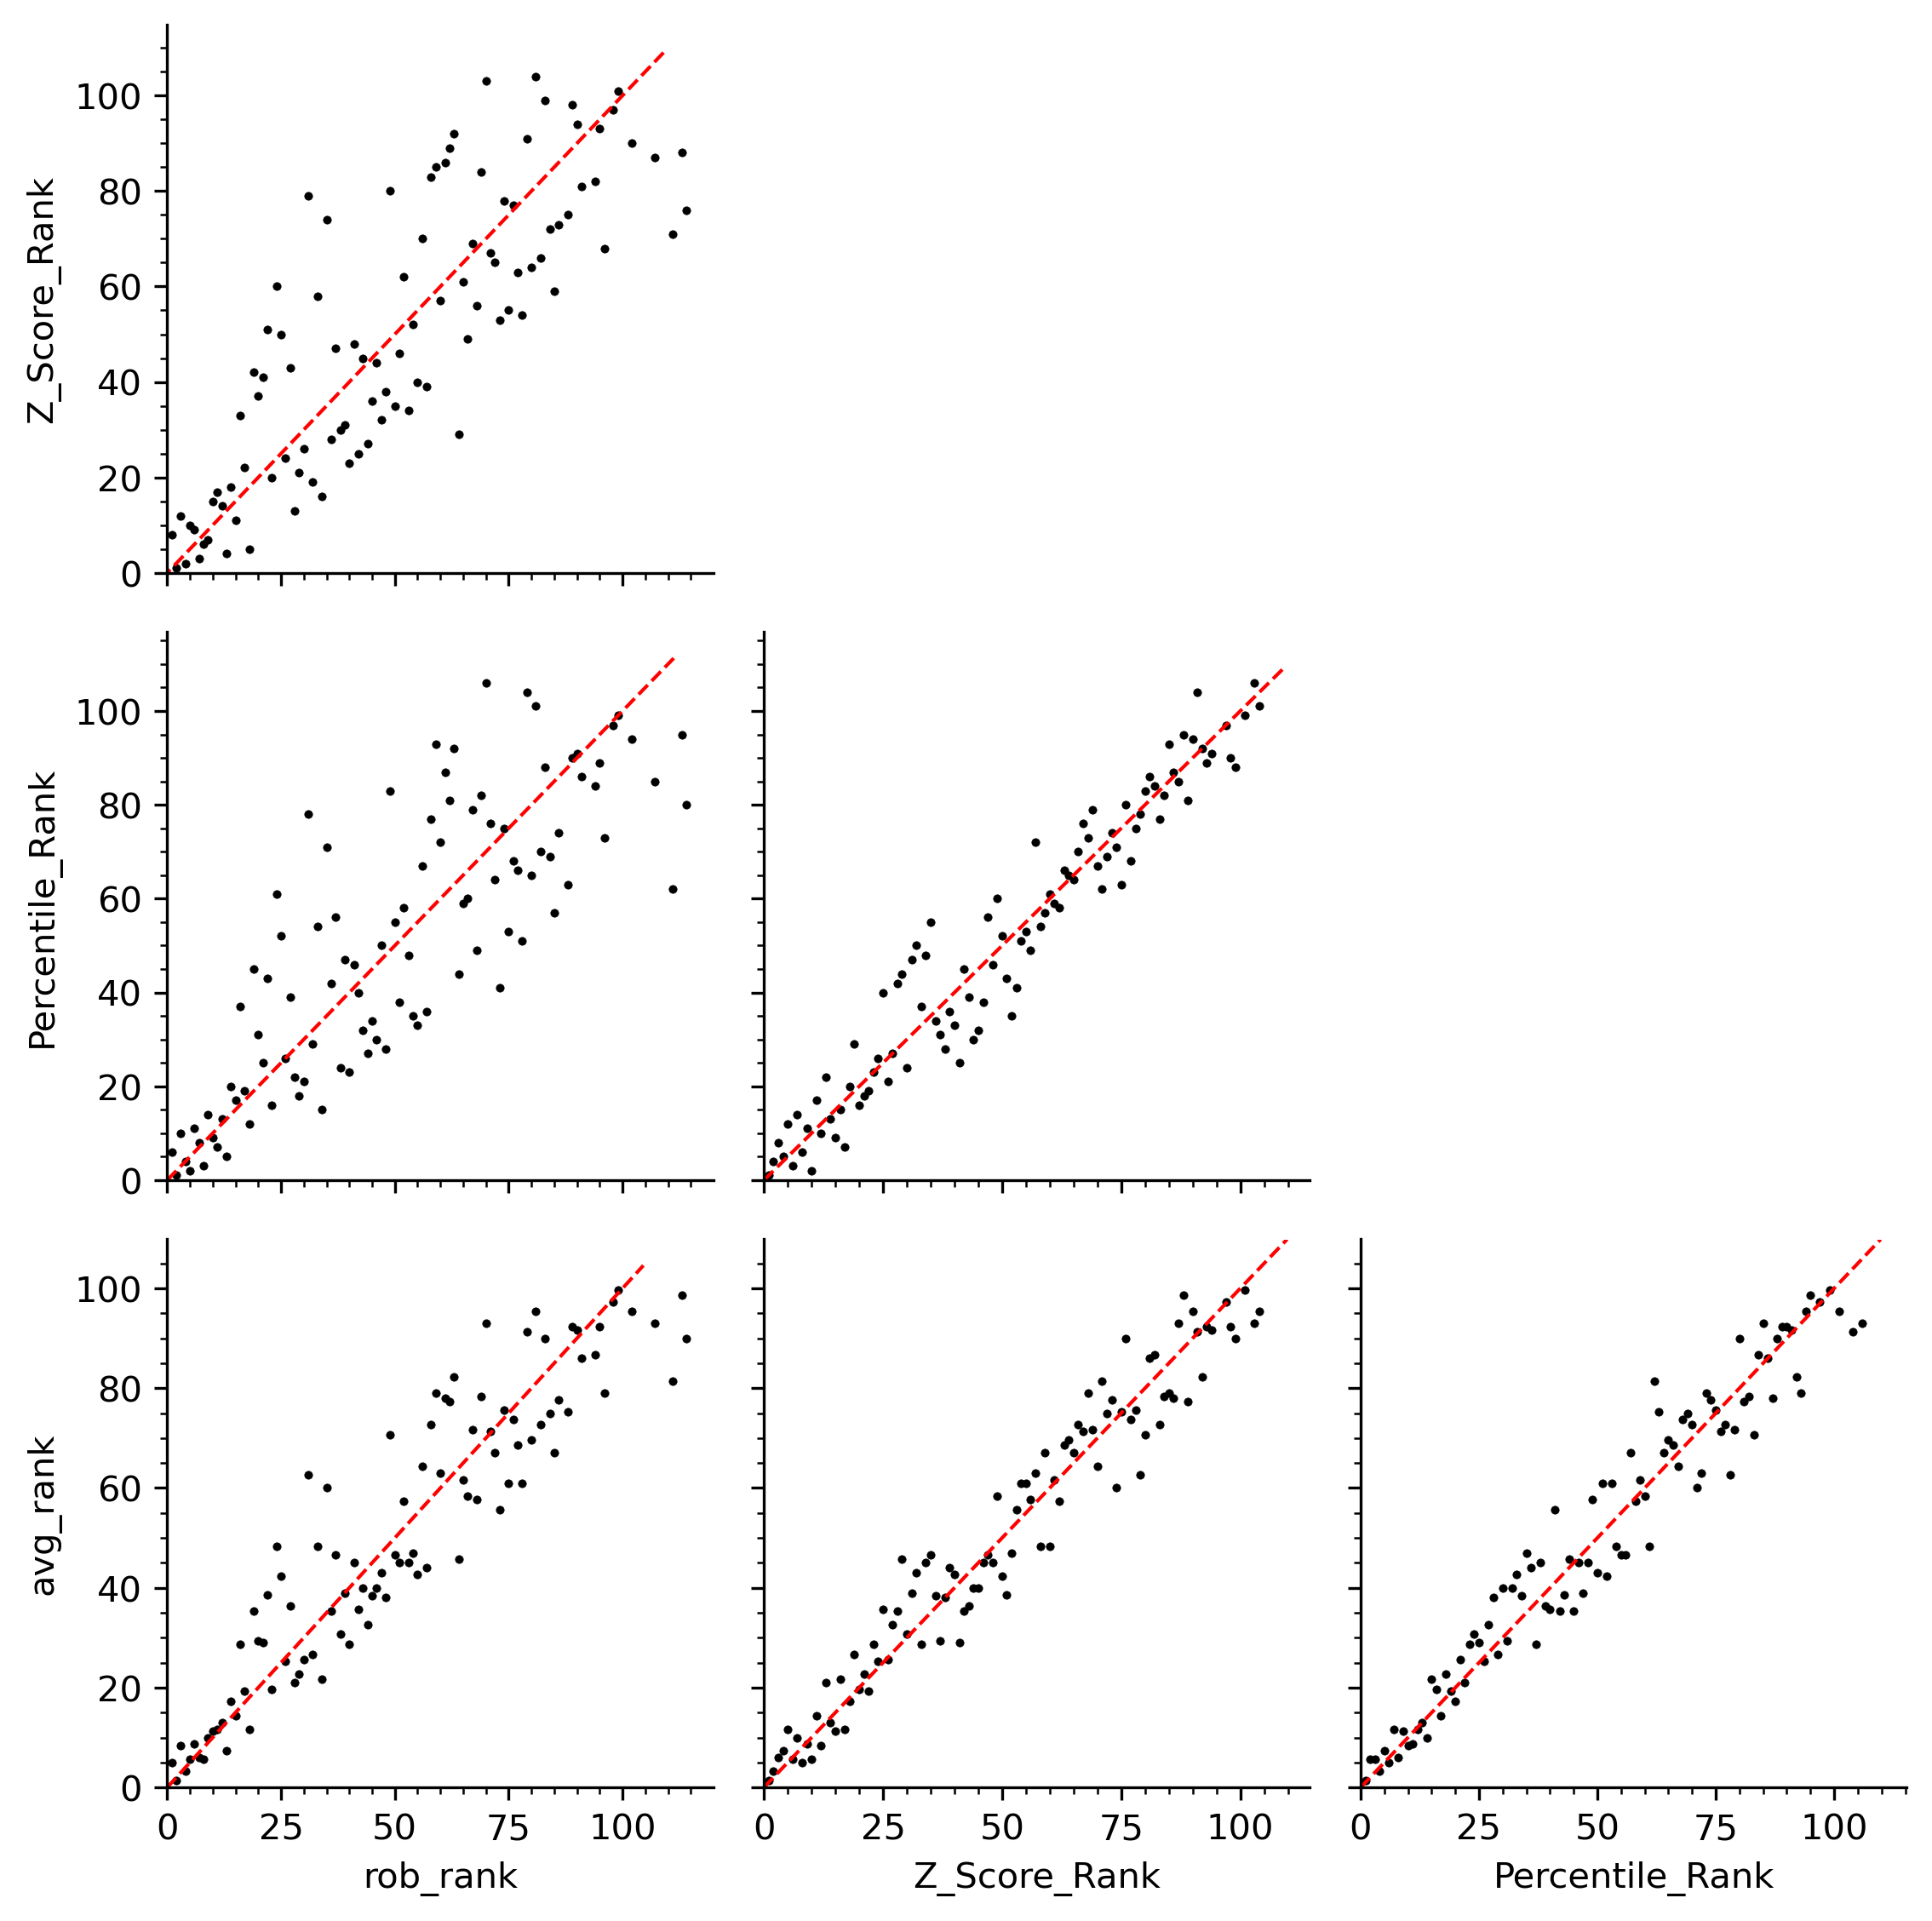

In [58]:


# Create the pairplot with black dots and disable default diagonal histograms
g = sns.pairplot(
    results.drop(columns=['Total_Puzzles']),
    plot_kws={'color': 'black', 's': 5, 'edgecolor':None},  # simple black dots, smaller size
    diag_kind=None,  # turn off histograms on the l
    corner=True,
)

g.fig.set_size_inches(10, 10)  # width, height in inches
g.fig.set_dpi(300)             # dots per inch (higher = better quality)

# Add 1-to-1 lines to the visible lower triangle scatter plots
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if i > j:  # lower triangle only
            ax = g.axes[i, j]
            limits = [
                max(ax.get_xlim()[0], ax.get_ylim()[0]),
                min(ax.get_xlim()[1], ax.get_ylim()[1])
            ]
            ax.plot(limits, limits, ls='--', color='red', lw=1)
            # ax.set_xlim(ax.get_xlim())
            # ax.set_ylim(ax.get_ylim())
            ax.set_xlim(0,None)
            ax.set_ylim(0,None)

for ax in g.axes.flat:
    if ax is not None:
        ax.minorticks_on()  # <-- enable minor ticks

for i in range(len(g.axes)):
        ax = g.axes[i, i]
        ax.set_visible(False)


plt.tight_layout()
plt.show()


In [1]:
import datetime
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import re



In [5]:
url = 'https://docs.google.com/spreadsheets/d/1aCENVOk-wroyW4-YS4OgtTTqr3rA-T9CZOjCQgALgSE/export?format=xlsx'
xls = pd.ExcelFile(url)

# exclude = {"_Competition Factors", "_JPAR Ratings", "_Latest JPAR Ratings", "_Histograms", "_UTILITY FUNCTIONS"}
# sheets_to_read = [s for s in xls.sheet_names if s not in exclude]
sheets_to_read = ['_JPAR Ratings']
dfs = {
    name: xls.parse(name)
    for name in sheets_to_read
}


In [6]:
dfs['_JPAR Ratings']

,Event Name,Event Date,Player Name,JPAR In,JPAR Out,Competition Count,Current Event Tier,All-Time Average Tier,12-Month Average Tier,Weighted JPAR Contribution,Ave Weighted JPAR Contribution,Player Rank,Avg JPAR In (Event),12-Month Avg JPAR In,Completion Time,12-Month Avg Completion Time
0,Worlds 2019 - Individual,2019-09-24,Jana Ondroušková,NaN,0.360031,1,1.0,1.000000,1.000000,0.75,0.750000,1.0,NaN,NaN,46.583333,46.583333
1,Worlds 2019 - Individual,2019-09-24,Mariusz Ślizewski,NaN,0.405115,1,1.0,1.000000,1.000000,0.75,0.750000,2.0,NaN,NaN,52.416667,52.416667
2,Worlds 2019 - Individual,2019-09-24,Kateřina Klinková,NaN,0.408335,1,1.0,1.000000,1.000000,0.75,0.750000,3.0,NaN,NaN,52.833333,52.833333
3,Worlds 2019 - Individual,2019-09-24,Sarah Mills,NaN,0.428173,1,1.0,1.000000,1.000000,0.75,0.750000,4.0,NaN,NaN,55.400000,55.400000
4,Worlds 2019 - Individual,2019-09-24,Ana Gil Luciano,NaN,0.429976,1,1.0,1.000000,1.000000,0.75,0.750000,5.0,NaN,NaN,55.633333,55.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20531,III Concurso de puzzles de Viveiro,2025-02-23,Ana Guillén García,NaN,1.477364,1,NaN,0.000000,0.000000,0.75,0.750000,27.0,0.955175,0.955175,196.721311,196.721311
20532,III Concurso de puzzles de Viveiro,2025-02-23,Lorena Barreno De Pablos,1.178763,1.289865,9,NaN,2.111111,1.800000,0.75,0.722222,28.0,0.955175,0.934249,201.342282,181.762006
20533,III Concurso de puzzles de Viveiro,2025-02-23,Mª Carmen Martínez Rodríguez,NaN,1.675078,1,NaN,0.000000,0.000000,0.75,0.750000,29.0,0.955175,0.955175,223.048327,223.048327
20534,III Concurso de puzzles de Viveiro,2025-02-23,Rodrigo Jurado Villalobos,NaN,1.687625,1,NaN,0.000000,0.000000,0.75,0.750000,30.0,0.955175,0.955175,224.719101,224.719101


In [16]:
for name, df in dfs.items():
    fullname = df['Event'].iloc[0]
    df['Full_Event'] = fullname
    print(name)
    print(df)

W19Ind
     Rank                              Name      Time  Remaining        PPM  \
0       1                  Jana Ondroušková  00:46:35        NaN  10.733453   
1       2                 Mariusz Ślizewski  00:52:25        NaN   9.538951   
2       3                 Kateřina Klinková  00:52:50        NaN   9.463722   
3       4                       Sarah Mills  00:55:24        NaN   9.025271   
4       5                   Ana Gil Luciano  00:55:38        NaN   8.987418   
..    ...                               ...       ...        ...        ...   
194   195                     Joseph Kasozi  02:00:00      313.0   1.558333   
195   196      Agustín De la Rosa Hernández  02:00:00      314.0   1.550000   
196   197  Maria Alexandra Duarte Rodrigues  02:00:00      324.0   1.466667   
197   198                     Arnold Jacobs  02:00:00      327.0   1.441667   
198   199                  Dora Maria Polle  02:00:00      364.0   1.133333   

     Relative Rank       Date  Pieces       

In [18]:
for name, df in dfs.items():
    df['Event'] = name

combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df = combined_df.drop(columns=['Unnamed: 11', 'Unnamed: 12'], errors='ignore')

def time_to_seconds(time_str):
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except Exception:
        return np.nan

combined_df['time_in_seconds'] = combined_df['Time'].apply(time_to_seconds)

def clean_remaining(val):
    if pd.isna(val):
        return 0
    if isinstance(val, str) and re.fullmatch(r"\d{1,2}:\d{2}:\d{2}", val):
        return 0
    return val

combined_df["Remaining"] = combined_df["Remaining"].apply(clean_remaining)

combined_df['time_penalty'] = (((500 - combined_df['Remaining']) / combined_df['time_in_seconds'])**(-1)) * combined_df['Remaining']
combined_df['corrected_time'] = combined_df['time_penalty'] + combined_df['time_in_seconds']

## DATA CLEANING
combined_df['Name'] = combined_df['Name'].str.strip()
combined_df['Pieces'] = pd.to_numeric(combined_df['Pieces'],errors='coerce')

In [19]:
combined_df

,Rank,Name,Time,Remaining,PPM,Relative Rank,Date,Pieces,Event,Players,Spread Diff,Full_Event,time_in_seconds,time_penalty,corrected_time
0,1.0,Jana Ondroušková,00:46:35,0.0,10.733453,2.528086,2019-09-24,500.0,W19Ind,1,3.102035,Worlds 2019 - Individual,2795.0,0.000000,2795.000000
1,2.0,Mariusz Ślizewski,00:52:25,0.0,9.538951,2.246741,2019-09-24,500.0,W19Ind,1,2.492723,Worlds 2019 - Individual,3145.0,0.000000,3145.000000
2,3.0,Kateřina Klinková,00:52:50,0.0,9.463722,2.229022,2019-09-24,500.0,W19Ind,1,2.454349,Worlds 2019 - Individual,3170.0,0.000000,3170.000000
3,4.0,Sarah Mills,00:55:24,0.0,9.025271,2.125752,2019-09-24,500.0,W19Ind,1,2.230696,Worlds 2019 - Individual,3324.0,0.000000,3324.000000
4,5.0,Ana Gil Luciano,00:55:38,0.0,8.987418,2.116836,2019-09-24,500.0,W19Ind,1,2.211388,Worlds 2019 - Individual,3338.0,0.000000,3338.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23612,27.0,Ana Guillén García,02:00:00,195.0,2.541667,0.592971,2025-02-23,500.0,ae326,1,-1.181252,III Concurso de puzzles de Viveiro,7200.0,4603.278689,11803.278689
23613,28.0,Lorena Barreno De Pablos,02:00:00,202.0,2.483333,0.579362,2025-02-23,500.0,ae326,1,-1.220247,III Concurso de puzzles de Viveiro,7200.0,4880.536913,12080.536913
23614,29.0,Mª Carmen Martínez Rodríguez,02:00:00,231.0,2.241667,0.522981,2025-02-23,500.0,ae326,1,-1.381802,III Concurso de puzzles de Viveiro,7200.0,6182.899628,13382.899628
23615,30.0,Rodrigo Jurado Villalobos,02:00:00,233.0,2.225,0.519092,2025-02-23,500.0,ae326,1,-1.392943,III Concurso de puzzles de Viveiro,7200.0,6283.146067,13483.146067


In [21]:
combined_df.to_pickle('./data/250519_scape_with_event_names.pkl')

In [2]:
df

,Rank,Name,Time,Remaining,PPM,Relative Rank,Date,Pieces,Event,Players,Spread Diff,time_in_seconds,time_penalty,corrected_time
0,1.0,Jana Ondroušková,00:46:35,0.0,10.733453,2.528086,2019-09-24,500,W19Ind,1,3.102035,2795.0,0.000000,2795.000000
1,2.0,Mariusz Ślizewski,00:52:25,0.0,9.538951,2.246741,2019-09-24,500,W19Ind,1,2.492723,3145.0,0.000000,3145.000000
2,3.0,Kateřina Klinková,00:52:50,0.0,9.463722,2.229022,2019-09-24,500,W19Ind,1,2.454349,3170.0,0.000000,3170.000000
3,4.0,Sarah Mills,00:55:24,0.0,9.025271,2.125752,2019-09-24,500,W19Ind,1,2.230696,3324.0,0.000000,3324.000000
4,5.0,Ana Gil Luciano,00:55:38,0.0,8.987418,2.116836,2019-09-24,500,W19Ind,1,2.211388,3338.0,0.000000,3338.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23612,27.0,Ana Guillén García,02:00:00,195.0,2.541667,0.592971,2025-02-23,500,ae326,1,-1.181252,7200.0,4603.278689,11803.278689
23613,28.0,Lorena Barreno De Pablos,02:00:00,202.0,2.483333,0.579362,2025-02-23,500,ae326,1,-1.220247,7200.0,4880.536913,12080.536913
23614,29.0,Mª Carmen Martínez Rodríguez,02:00:00,231.0,2.241667,0.522981,2025-02-23,500,ae326,1,-1.381802,7200.0,6182.899628,13382.899628
23615,30.0,Rodrigo Jurado Villalobos,02:00:00,233.0,2.225,0.519092,2025-02-23,500,ae326,1,-1.392943,7200.0,6283.146067,13483.146067


In [6]:
df['time_in_seconds'].argmin()

7173

In [7]:
df.iloc[7173]


Rank                               1.0
Name                       Kate Mixson
Time                          00:18:16
Remaining                          0.0
PPM                          16.423358
Relative Rank                  1.87865
Date               2024-03-09 00:00:00
Pieces                             300
Event                            sp182
Players                              1
Spread Diff                   2.790583
time_in_seconds                 1096.0
time_penalty                       0.0
corrected_time                  1096.0
Name: 7173, dtype: object

In [16]:
df['Pieces'] = pd.to_numeric(df['Pieces'], errors='coerce')

In [1]:
df['Pieces'].sum()

NameError: name 'df' is not defined

In [6]:
df['Pieces'].dropna()

0        500
1        500
2        500
3        500
4        500
        ... 
23612    500
23613    500
23614    500
23615    500
23616    500
Name: Pieces, Length: 23617, dtype: object